# Intro
<font size=4> This Notebook gives u guys a gentle introduction towards the QA labeling Competition, which includes a detailed EDA about the dataset and a benchmark Keras DNN model with Word2Vec. Wish you Happy Kaggling!

In [1]:
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import random
import gc
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
random.seed(1234)

In [2]:
train_df = pd.read_csv('../input/google-quest-challenge/train.csv')
test_df = pd.read_csv('../input/google-quest-challenge/test.csv')

# the dataset size
print('train set size is %d' % len(train_df))
print('test set size is %d' % len(test_df))

train set size is 6079
test set size is 476


In [3]:
feat_cols = [
    'question_title', 
    'question_body', 
    'question_user_name', 
    'question_user_page', 
    'answer', 
    'answer_user_name', 
    'answer_user_page', 
    'url', 
    'category', 
    'host']
target_cols = [
    'question_asker_intent_understanding', 
    'question_body_critical', 
    'question_conversational', 
    'question_expect_short_answer', 
    'question_fact_seeking', 
    'question_has_commonly_accepted_answer',
    'question_interestingness_others', 
    'question_interestingness_self', 
    'question_multi_intent', 
    'question_not_really_a_question', 
    'question_opinion_seeking', 
    'question_type_choice',
    'question_type_compare', 
    'question_type_consequence', 
    'question_type_definition', 
    'question_type_entity', 
    'question_type_instructions', 
    'question_type_procedure', 
    'question_type_reason_explanation', 
    'question_type_spelling',
    'question_well_written', 
    'answer_helpful', 
    'answer_level_of_information', 
    'answer_plausible', 
    'answer_relevance', 
    'answer_satisfaction', 
    'answer_type_instructions', 
    'answer_type_procedure', 
    'answer_type_reason_explanation',
    'answer_well_written'
]

print('we have %d feature columns and %d target columns' % (len(feat_cols) , len(target_cols)))

we have 10 feature columns and 30 target columns


<font size=4>Now a quick look for one sample</font>

In [4]:
peek = train_df.sample()
text_cols = [
    'question_title',
    'question_body',
    'answer'
]

for col_name in feat_cols + target_cols:
    print(col_name)
    print('='* 10)
    print(str(peek[col_name].values[0]) + '\n')

question_title
call/cc implementation?

question_body
I'm trying to find how call/cc is implemented. The best I've found is this Haskell snippet:

callCC f = Cont $ \k -&gt; runCont (f (\a -&gt; Cont $ \_ -&gt; k a)) k


Although this is not as simple as I want due to the Cont and runCont. I've also found descriptions of what it does, although never as clear as actual code.

So how is it implemented in its simplest form? I am tagging this with Scheme and Haskell as those are two languages I prefer.


question_user_name
Pubby

question_user_page
https://stackoverflow.com/users/964135

answer
"Implementing call/cc" doesn't really make sense at the layer you're working in; if you can implement call/cc in a language, that just means it has a built-in construct at least as powerful as call/cc. At the level of the language itself, call/cc is basically a primitive control flow operator, just like some form of branching must be.

Of course, you can implement a language with call/cc in a langua

# Inspect Feature Variables

## 1. question_title

<font size=4> Here are many duplicated question titles. The higest one named 'What is the best introductory Bayesian statistics textbook?' attracts 12 answers in the trainset.</font>

In [5]:
train_df.groupby('question_title').count()['qa_id'].sort_values(ascending=False)

question_title
What is the best introductory Bayesian statistics textbook?                                12
What does mathematics have to do with programming?                                         11
Important non-technical course for programmers?                                            11
How to prevent the "Too awesome to use" syndrome                                            9
Another instructor is pushing me out of the classroom right after my class ends             7
                                                                                           ..
How to get the sales order date from the REST api?                                          1
How to get three grayscale images from a RGB photo in PS?                                   1
Using limits to prove a function is in the order of another function                        1
How to have remote standby PostgreSQL server in different location (AWS)?                   1
Is there a difference between pulling the plu

In [6]:
# take a closer look to the most popular question
train_df[train_df['question_title'] == 'What is the best introductory Bayesian statistics textbook?'][feat_cols]

,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
229,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,"""Bayesian Core: A Practical Approach to Comput...",gappy,https://stats.stackexchange.com/users/30,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com
1616,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,I am now reading : From Algorithm to Z-Scores:...,Fabio,https://stats.stackexchange.com/users/40316,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com
1647,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,"My favorite is ""Bayesian Data Analysis"" by Gel...",Shane,https://stats.stackexchange.com/users/5,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com
2104,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,I have read some parts of A First Course in Ba...,George Dontas,https://stats.stackexchange.com/users/339,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com
3476,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,"Sivia and Skilling, Data analysis: a Bayesian ...",denis,https://stats.stackexchange.com/users/557,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com
3762,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,If I had to choose a single text for a beginne...,Jim Stone,https://stats.stackexchange.com/users/26779,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com
3801,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,"Take a look at ""The Bayesian Choice"". It has t...",Zen,https://stats.stackexchange.com/users/9394,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com
3899,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,I found an excellent introduction in Gelman an...,Jack Tanner,https://stats.stackexchange.com/users/8207,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com
4408,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,Its focus isn't strictly on Bayesian statistic...,Joe,https://stats.stackexchange.com/users/1119,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com
5239,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,I read:\n\nGelman et al (2013). Bayesian Data ...,stochazesthai,https://stats.stackexchange.com/users/44171,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com


**NOTE:**
<font size=4>
    <p>*question_title*, *question_body*, *question_user_page*, *url* and etc. are bounded together.</p>
    <p>ALSO The asker might answer his own question [see row 1647 in the above example].</p>
</font>

## 2. Category & Host
<font size=4> The Distribution over category and host</font>

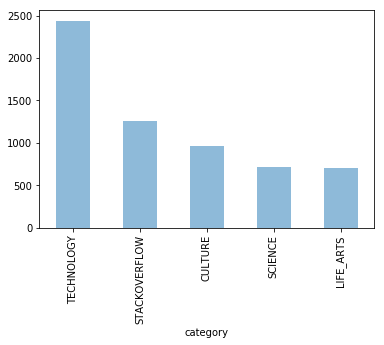

In [7]:
train_df.groupby('category').count()['qa_id'].sort_values(ascending=False).plot(kind='bar', alpha=0.5)

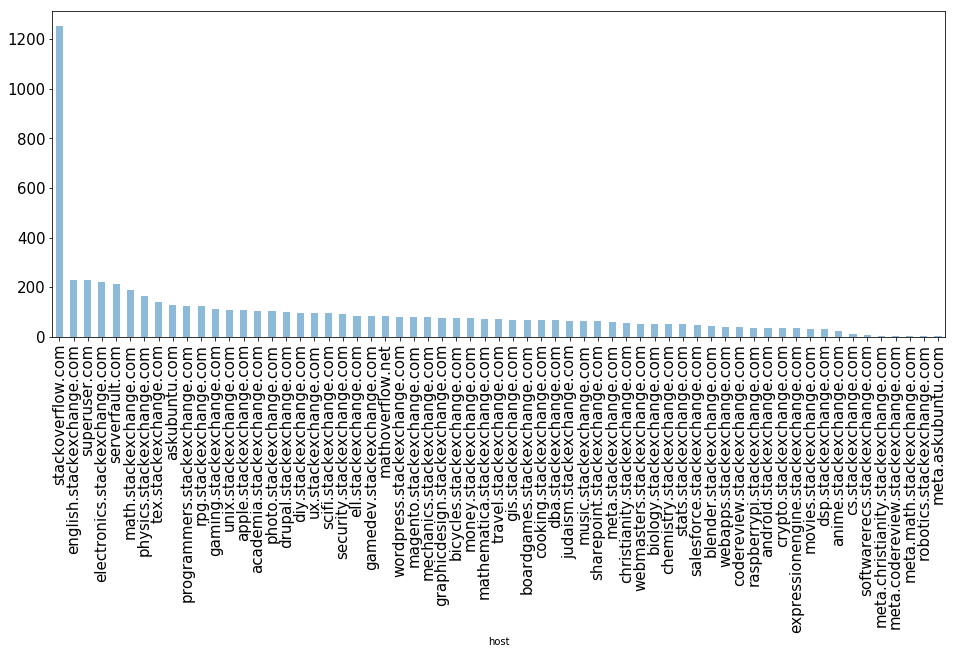

In [8]:
train_df.groupby('host').count()['qa_id'].sort_values(ascending=False).plot(kind='bar', figsize=(16, 6), fontsize=15, alpha=0.5)

## 4. Answer User Name & Question User Name
<font size=4> Who is the most active user </font>

<font size=4> Here lists the top5 active answer user

In [9]:
train_df.groupby('answer_user_name').count()['qa_id'].sort_values(ascending=False)[:5]

answer_user_name
Scott       20
egreg       18
Alex        16
Marius      16
Andy aka    14
Name: qa_id, dtype: int64

<font size=4> **Scott** seems not just one person.

In [10]:
train_df[train_df['answer_user_name'] == 'Scott'][['answer_user_name', 'question_title', 'category', 'host']].sort_values(by='category')

,answer_user_name,question_title,category,host
1683,Scott,"Does adding a comma before ""or"" change the mea...",CULTURE,ell.stackexchange.com
213,Scott,How can I remove an existing Gradient Mesh fro...,LIFE_ARTS,graphicdesign.stackexchange.com
4212,Scott,adobe illustrator - linework and paintbucket o...,LIFE_ARTS,graphicdesign.stackexchange.com
4175,Scott,Too many compound paths in illustrator.. need ...,LIFE_ARTS,graphicdesign.stackexchange.com
3588,Scott,Is a Photoshop EPS file a vector format?,LIFE_ARTS,graphicdesign.stackexchange.com
3540,Scott,Is it copyright infringement by US copyright l...,LIFE_ARTS,graphicdesign.stackexchange.com
3521,Scott,"Illustrator, snap to guide",LIFE_ARTS,graphicdesign.stackexchange.com
3198,Scott,What is the best icon to represent the shoppin...,LIFE_ARTS,graphicdesign.stackexchange.com
3097,Scott,Custom stroke caps in Illustrator?,LIFE_ARTS,graphicdesign.stackexchange.com
2897,Scott,What size should I make the line art for a one...,LIFE_ARTS,graphicdesign.stackexchange.com


----------------
<font size=4 >Here lists the top5 active question user

In [11]:
train_df.groupby(['question_user_name']).count()['qa_id'].sort_values(ascending=False).iloc[:5]

question_user_name
Mike          15
Alex          14
Shane         12
Louis Rhys    11
David         11
Name: qa_id, dtype: int64

<font size=4>A closer look to Mike</font>

In [12]:
train_df[train_df['question_user_name'] == 'Mike'][['question_user_name', 'question_title', 'category', 'host']].sort_values(by=['category', 'question_title'])

,question_user_name,question_title,category,host
5777,Mike,Does Jesus eat food in heaven?,CULTURE,christianity.stackexchange.com
374,Mike,What does it mean to interpret the Bible liter...,CULTURE,christianity.stackexchange.com
1328,Mike,What does it mean to interpret the Bible liter...,CULTURE,christianity.stackexchange.com
2885,Mike,What does it mean to interpret the Bible liter...,CULTURE,christianity.stackexchange.com
670,Mike,Any smart way to get the interest down on our ...,LIFE_ARTS,money.stackexchange.com
1333,Mike,VB.net Service Programming and using TCP Sockets,STACKOVERFLOW,stackoverflow.com
2029,Mike,Visual Studio profiler not finding symbols whe...,STACKOVERFLOW,stackoverflow.com
718,Mike,I can't get MySQL56 service to start after i s...,TECHNOLOGY,dba.stackexchange.com
5855,Mike,I can't get MySQL56 service to start after i s...,TECHNOLOGY,dba.stackexchange.com
1297,Mike,Removing blanks from a column in Excel,TECHNOLOGY,superuser.com


## 5. Text

<font size=4> Let's see the distribution of text length

In [13]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

TOKENIZER = RegexpTokenizer(r'\w+')
STOPWORDS = set(stopwords.words('english'))

In [14]:
train_df['question_title_len'] = train_df['question_title'].map(lambda x: len(TOKENIZER.tokenize(x)))
train_df['question_body_len'] = train_df['question_body'].map(lambda x: len(TOKENIZER.tokenize(x)))
train_df['answer_len'] = train_df['answer'].map(lambda x: len(TOKENIZER.tokenize(x)))

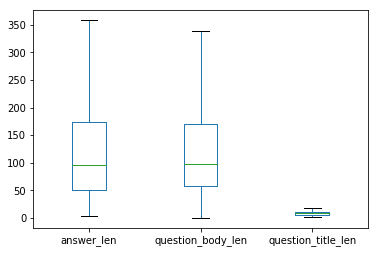

In [15]:
train_df[['answer_len', 'question_body_len', 'question_title_len']].plot(kind='box', showfliers=False)

<font size=4>Now see the word distribution

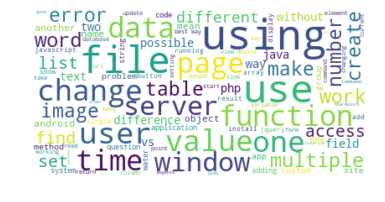

In [16]:
def gen_word_cloud(col):
    rows = train_df[col].map(lambda x: TOKENIZER.tokenize(x)).values.tolist()
    words = []
    for row in rows:
        for w in row:
            if w not in STOPWORDS:
                words.append(w.lower())
    
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(words))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

gen_word_cloud('question_title')

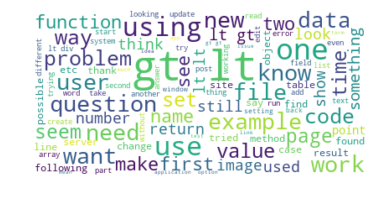

In [17]:
gen_word_cloud('question_body')

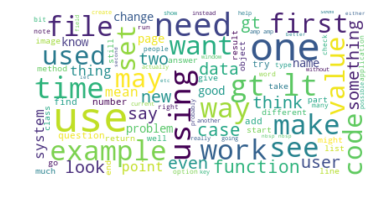

In [18]:
gen_word_cloud('answer')

-------------

# Inspect Target Variable

## 1. Variable Distribution

In [19]:
import re
question_related_target_cols = [ col for col in target_cols if re.search('^question_', col)]
answer_related_target_cols = [ col for col in target_cols if re.search('^answer_', col)]

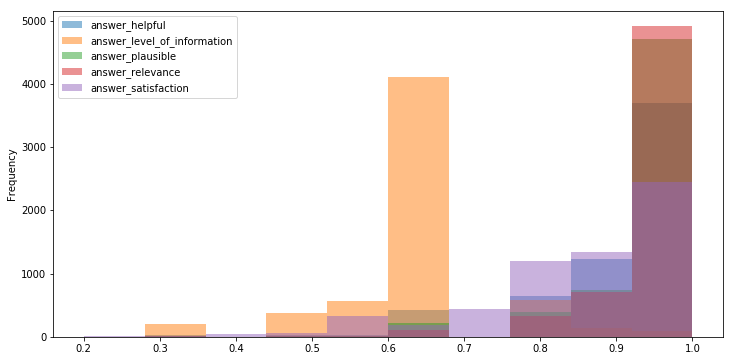

In [20]:
train_df[answer_related_target_cols[:5]].plot(kind='hist', figsize=(12, 6), alpha=0.5)

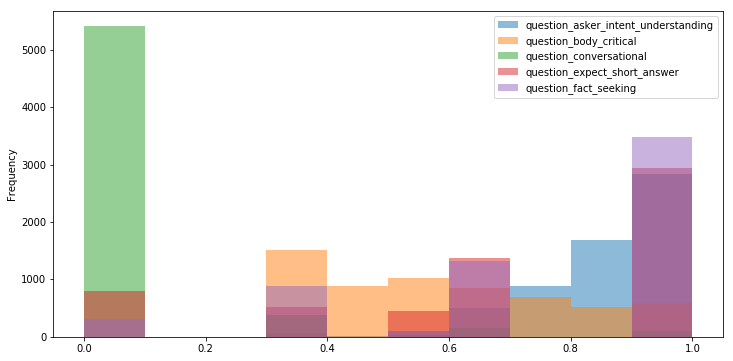

In [21]:
train_df[question_related_target_cols[:5]].plot(kind='hist', figsize=(12, 6), alpha=0.5)

## 2. Variable Correlations

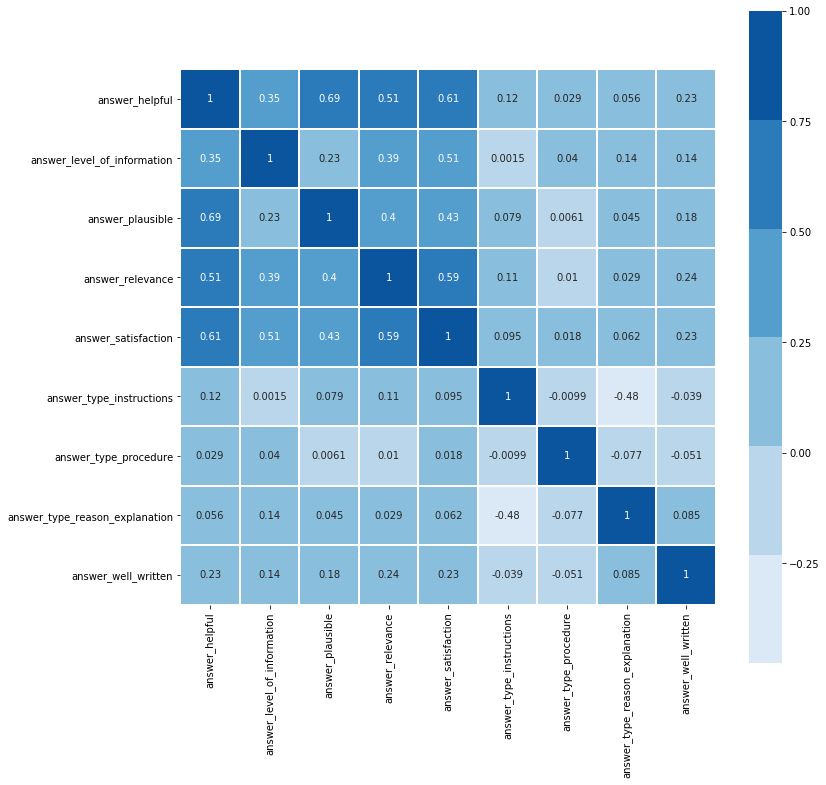

In [22]:
plt.figure(figsize=(12, 12))
sns.heatmap(data=train_df[answer_related_target_cols].corr(), 
            square=True, 
            annot=True,
            linewidths=1, 
            cmap=sns.color_palette("Blues"))

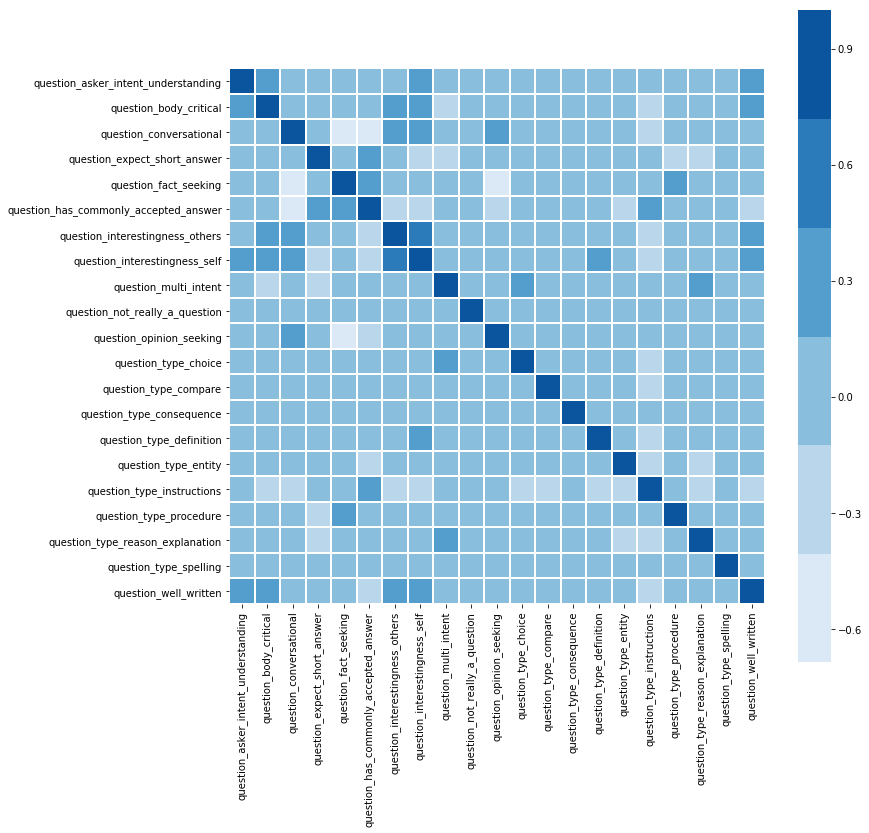

In [23]:
plt.figure(figsize=(12, 12))
sns.heatmap(data=train_df[question_related_target_cols].corr(), 
            square=True, 
            linewidths=1, 
            cmap=sns.color_palette("Blues"))

# Target vs Features

## 1. target vs Category

<font size=4> We compute the averages of several target values for each category, and display them with std as error bars. It seems some question related target variables are slighted affected by the category, while the question related ones are not. 

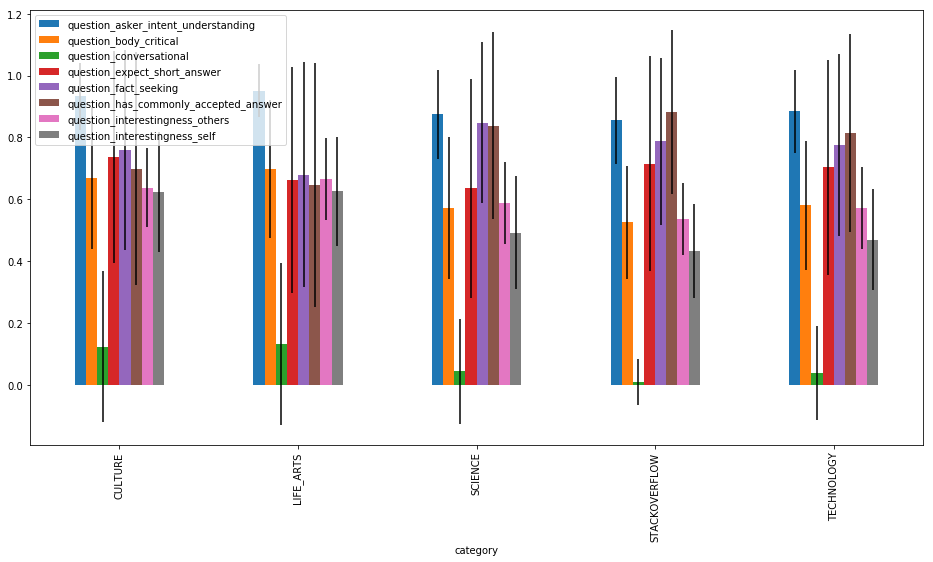

In [24]:
std = train_df.groupby('category')[question_related_target_cols[:8]].std()
train_df.groupby('category')[question_related_target_cols[:8]].mean().plot(kind='bar', figsize=(16, 8), 
                                                                           yerr=std)

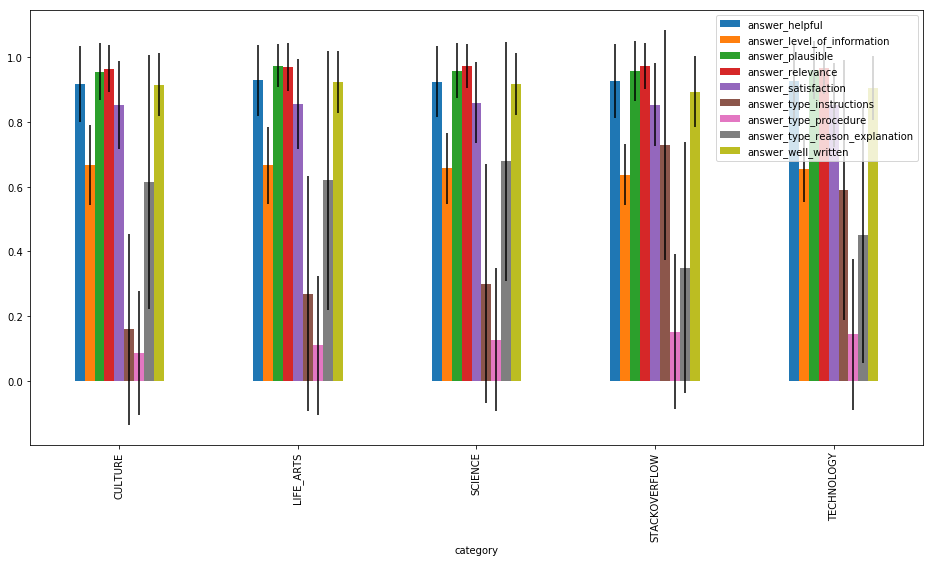

In [25]:
std = train_df.groupby('category')[answer_related_target_cols].std()
train_df.groupby('category')[answer_related_target_cols].mean().plot(kind='bar', figsize=(16, 8), 
                                                                           yerr=std)

## 2. target vs Host
<font size=4> we filter out some unfrequent host at first

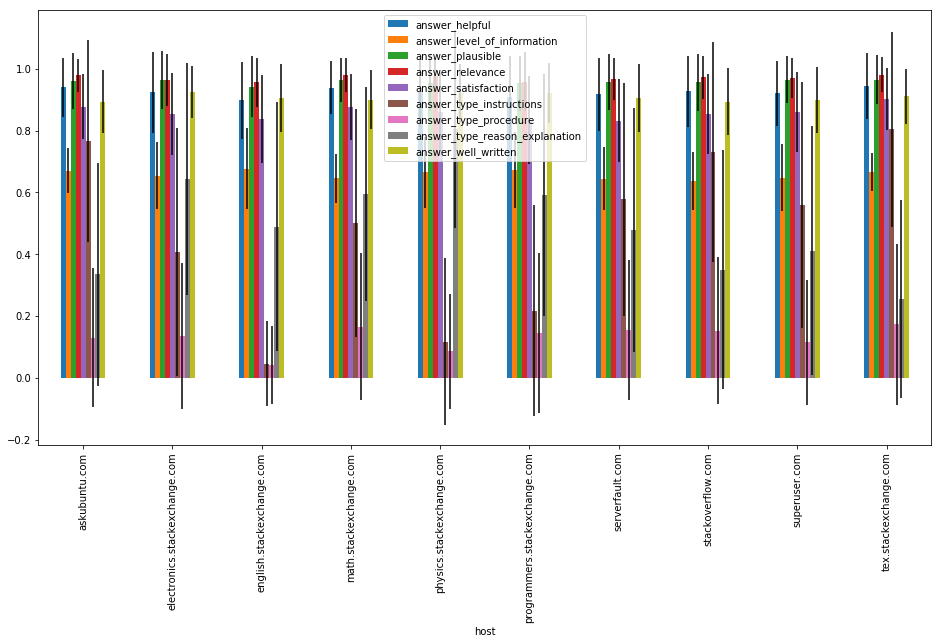

In [26]:
frequent_hosts = set(train_df.groupby('host').count()['qa_id'].sort_values(ascending=False)[:10].index)
idx = train_df['host'].map(lambda x: x in frequent_hosts)
train_subset = train_df[idx]

std = train_subset.groupby('host')[answer_related_target_cols].std()
train_subset.groupby('host')[answer_related_target_cols].mean().plot(kind='bar', figsize=(16, 8), yerr=std)

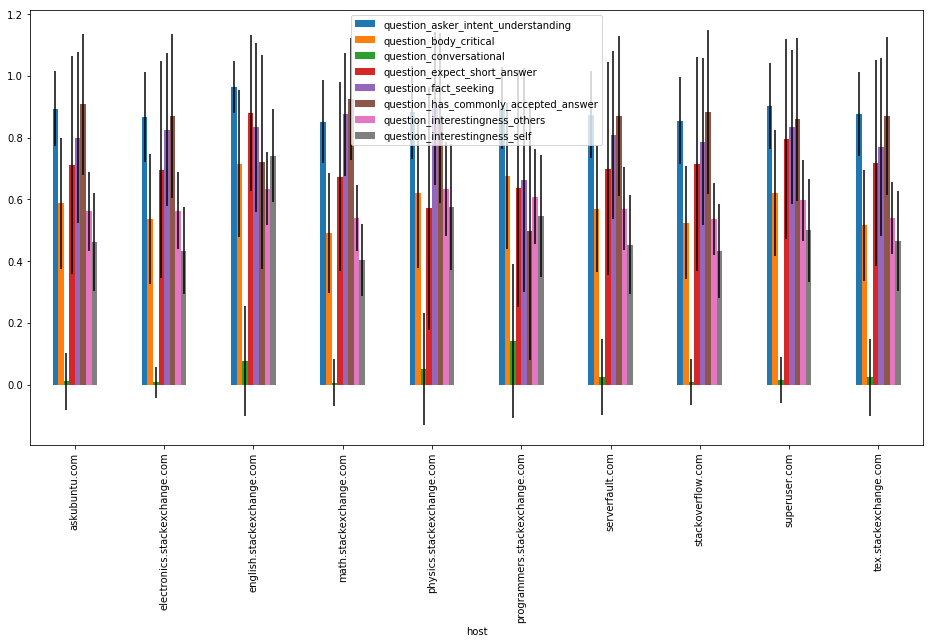

In [27]:
std = train_subset.groupby('host')[question_related_target_cols[:8]].std()
train_subset.groupby('host')[question_related_target_cols[:8]].mean().plot(kind='bar', figsize=(16, 8), yerr=std)

<font size=4> Still, some question realted target (*question_converstional*, *qustion_interestingness_self*, etc.) are sensitive to the *host*

## 3. target vs Text Len

<font size=4> the correlation between answer_level_of_information and answer_lne is 0.31.. make sense hah.

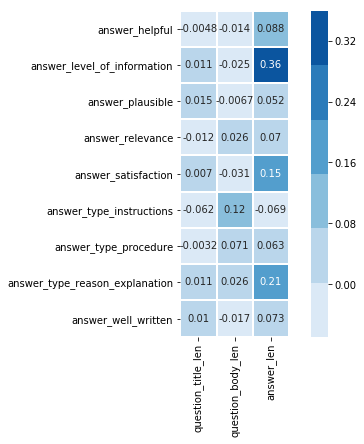

In [28]:
plt.figure(figsize=(8, 6))
text_len_cols = ['question_title_len', 'question_body_len', 'answer_len']
corr_with_text_len = train_df[answer_related_target_cols + text_len_cols].corr().loc[text_len_cols, answer_related_target_cols]
sns.heatmap(data=corr_with_text_len.T, 
            square=True, 
            linewidths=1, 
            annot=True,
            cmap=sns.color_palette("Blues"))

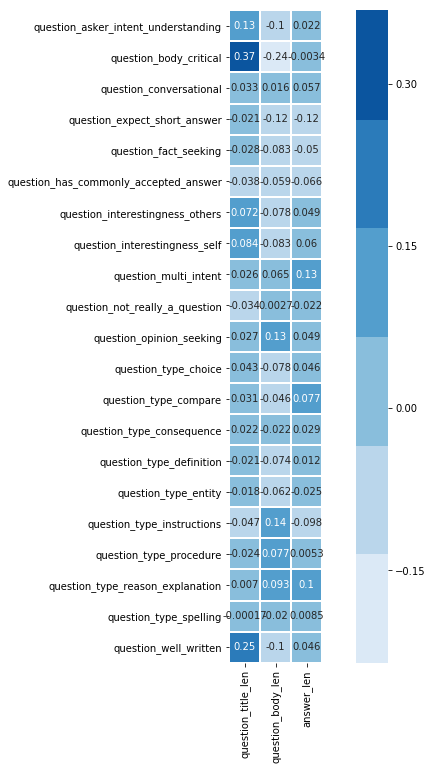

In [29]:
plt.figure(figsize=(12, 12))
corr_with_text_len = train_df[question_related_target_cols + text_len_cols].corr().loc[text_len_cols, question_related_target_cols]
sns.heatmap(data=corr_with_text_len.T, 
            square=True, 
            linewidths=1, 
            annot=True,
            cmap=sns.color_palette("Blues"))

------------------

# Benchmark with Word2Vec


## 1. Feature Engineering

<font size=4> <p> The techniques for text vectorization we use in this part are:
* TFIDF 
* SVD -- dimension reduction for the TFIDF weights --> the dimension for the dense representation is 300d
* Word2Vec (300d google news) -- we use the average over the word-vectors of each non-stop word in each passage of text </p>

<p> We also include the length of text as a feature. </p>

In [30]:
# load w2v model, this might take a few moments, grab a coffee and relax
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('../input/word2vec-google/GoogleNews-vectors-negative300.bin', binary=True, unicode_errors='ignore')

In [31]:
TFIDF_SVD_WORDVEC_DIM = 300

def get_text_feats(df, col):

    def tokenize_downcase_filtering(x):
        words = TOKENIZER.tokenize(x)
        lower_case = map(lambda w: w.lower(), words)
        content_words = filter(lambda w: w not in STOPWORDS, lower_case)
        return ' '.join(content_words)

    rows = df[col].map(tokenize_downcase_filtering).values.tolist()
    tfidf = TfidfVectorizer(tokenizer=lambda x: x.split(' '))  # dont use sklearn default tokenization tool 
    tfidf_weights = tfidf.fit_transform(rows)
    svd = TruncatedSVD(n_components=TFIDF_SVD_WORDVEC_DIM, n_iter=10)  # reduce dimensionality
    dense_tfidf_repr_mat = svd.fit_transform(tfidf_weights)
    
    word2vec_repr_mat = np.zeros((len(df), w2v_model.vector_size))
    for i, row in enumerate(rows):
        word2vec_accum = np.zeros((w2v_model.vector_size, ))
        word_cnt = 0
        for w in row.split(' '):
            if w in w2v_model.wv:
                word2vec_accum += w2v_model.wv[w]
                word_cnt += 1

        # compute the average for the wordvec of each non-sptop word
        if word_cnt != 0:
            word2vec_repr_mat[i] = word2vec_accum / word_cnt

    return  np.concatenate([word2vec_repr_mat, dense_tfidf_repr_mat], axis=1)  # word2vec + tfidf


def one_hot_feats(df, col):
    return pd.get_dummies(df['host'], prefix='host', drop_first=True).values


# let's build features
df_all = pd.concat((train_df, test_df))
df_all['question_title_len'] = df_all['question_title'].map(lambda x: len(TOKENIZER.tokenize(x)))
df_all['question_body_len'] = df_all['question_body'].map(lambda x: len(TOKENIZER.tokenize(x)))
df_all['answer_len'] = df_all['answer'].map(lambda x: len(TOKENIZER.tokenize(x)))

data = []
for col in text_cols:
    data.append(get_text_feats(df_all, col))

for col in ['category', 'host']:
    data.append(one_hot_feats(df_all, col))

data.append(df_all[text_len_cols].values)
data = np.concatenate(data, axis=1)

train_feats = data[:len(train_df)]
test_feats = data[len(train_df):]

# del w2v_model
# gc.collect()
print(train_feats.shape)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


(6079, 1929)


## 2. Build a DNN model

In [32]:
# code from https://www.kaggle.com/ryches/tfidf-benchmark
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import KFold
from keras.callbacks.callbacks import EarlyStopping
from scipy.stats import spearmanr

num_folds = 5
fold_scores = []
kf = KFold(n_splits=num_folds, shuffle=True, random_state=9102)

test_preds = np.zeros((len(test_feats), len(target_cols)))
for train_index, val_index in kf.split(train_feats):
    train_X = train_feats[train_index, :]
    train_y = train_df[target_cols].iloc[train_index]
    
    val_X = train_feats[val_index, :]
    val_y = train_df[target_cols].iloc[val_index]
    
    model = Sequential([
        Dense(512, input_shape=(train_feats.shape[1],)),
        Activation('tanh'),
        Dense(256),
        Activation('tanh'),
        Dense(len(target_cols)),
        Activation('sigmoid'),
    ])
    
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy')
    
    model.fit(train_X, train_y, epochs=50, validation_data=(val_X, val_y), callbacks = [es])
    preds = model.predict(val_X)
    overall_score = 0
    print('-'* 10)
    for i, col in enumerate(target_cols):
        overall_score += spearmanr(preds[:, i], val_y[col].values).correlation / len(target_cols)
        print('%s\t%.5f' % (col, spearmanr(preds[:, i], val_y[col].values).correlation))

    fold_scores.append(overall_score)
    test_preds += model.predict(test_feats) / num_folds
    
print(fold_scores)

Using TensorFlow backend.


Train on 4863 samples, validate on 1216 samples
Epoch 1/50
4863/4863 [==============================] - 1s 250us/step - loss: 0.4243 - val_loss: 0.4082
Epoch 2/50
4863/4863 [==============================] - 1s 134us/step - loss: 0.4032 - val_loss: 0.3999
Epoch 3/50
4863/4863 [==============================] - 1s 121us/step - loss: 0.3959 - val_loss: 0.3967
Epoch 4/50
4863/4863 [==============================] - 1s 126us/step - loss: 0.3903 - val_loss: 0.3959
Epoch 5/50
4863/4863 [==============================] - 1s 125us/step - loss: 0.3862 - val_loss: 0.3916
Epoch 6/50
4863/4863 [==============================] - 1s 135us/step - loss: 0.3812 - val_loss: 0.3898
Epoch 7/50
4863/4863 [==============================] - 1s 123us/step - loss: 0.3783 - val_loss: 0.3924
Epoch 8/50
4863/4863 [==============================] - 1s 119us/step - loss: 0.3734 - val_loss: 0.3908
Epoch 9/50
4863/4863 [==============================] - 1s 128us/step - loss: 0.3715 - val_loss: 0.3925
Epoch 10/50
4863

## 3. Submit

In [33]:
sub = pd.read_csv("../input/google-quest-challenge/sample_submission.csv")
for i, col in enumerate(target_cols):
    sub[col] = test_preds[:, i]
sub.to_csv("submission.csv", index = False)

In [34]:
sub

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.911633,0.558608,0.046240,0.678173,0.788265,0.841767,0.609928,0.532545,0.321172,...,0.827183,0.903150,0.603052,0.944147,0.958469,0.789041,0.240972,0.091591,0.689477,0.900533
1,46,0.886848,0.510424,0.006217,0.659341,0.751103,0.891903,0.549025,0.456212,0.134743,...,0.756337,0.944088,0.635759,0.970025,0.975568,0.864975,0.902452,0.161917,0.101804,0.896087
2,70,0.909243,0.594080,0.027201,0.657979,0.917511,0.899319,0.598295,0.526966,0.382879,...,0.861751,0.882984,0.578996,0.928443,0.941512,0.774361,0.083590,0.054873,0.709184,0.896511
3,132,0.843992,0.377845,0.017230,0.679306,0.670067,0.834048,0.545313,0.430465,0.260403,...,0.711765,0.938674,0.649118,0.959153,0.976215,0.843042,0.728322,0.177866,0.556701,0.909303
4,200,0.940252,0.582022,0.052201,0.794766,0.788879,0.771822,0.635448,0.596360,0.402559,...,0.847205,0.929561,0.647080,0.970805,0.969662,0.826205,0.273818,0.163599,0.554841,0.921632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,9569,0.894031,0.586212,0.009628,0.730705,0.823129,0.870054,0.584011,0.477617,0.136104,...,0.789771,0.951986,0.704252,0.977044,0.984965,0.898452,0.844840,0.197617,0.286936,0.906803
472,9590,0.839074,0.510531,0.008078,0.771407,0.802425,0.836362,0.562770,0.439521,0.065346,...,0.697199,0.946877,0.654401,0.961619,0.977834,0.873077,0.838752,0.166151,0.198288,0.887583
473,9597,0.850566,0.401383,0.018897,0.653792,0.704860,0.795084,0.539512,0.440355,0.248379,...,0.713146,0.918408,0.612621,0.953090,0.966573,0.786207,0.713398,0.170172,0.284951,0.913793
474,9623,0.944722,0.618388,0.079456,0.858153,0.836424,0.856639,0.635903,0.588744,0.187234,...,0.858362,0.952321,0.752823,0.973497,0.980710,0.911605,0.078864,0.072248,0.866896,0.931138
